## Autoencoder for Earthquake triggered ground motion using fourier spectral amplitudes

In [1]:
%matplotlib inline
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
import math
from mpl_toolkits.basemap import Basemap

### read and prepare data

In [39]:
## read synth Frequency Amplitude Spectra and corresponding Magnitude and Distance values
data_FAS = pd.read_csv('synthData/Specvals_test.csv',sep = ',', low_memory=False, header=None)
data_M_D = pd.read_csv('synthData/MagDistvals_test.csv',sep = ',', low_memory=False, header=None)

## get frequency values from original data file
data_all = pd.read_csv('ESM_flatfile_FAS.csv',sep = ';', low_memory=False)
FAS_U_labels = [x for x in data_all.columns if 'U_F' in x]
frequencies  = [float(x[3:].replace("_", ".")) for x in FAS_U_labels]
n_freq       = len(frequencies)

In [40]:
## convert FAS to log-scale
eps   = 10**(-8)
data  = np.log10(np.asarray(data_FAS) + eps)

print("Data set dimension:", data.shape)

Data set dimension: (1000, 103)


#### Control of input data. 
Distance-magnitude plot colored by amplitudes of different frequencies should reveal high amplitudes for large magnitudes and small distances and vice versa. 

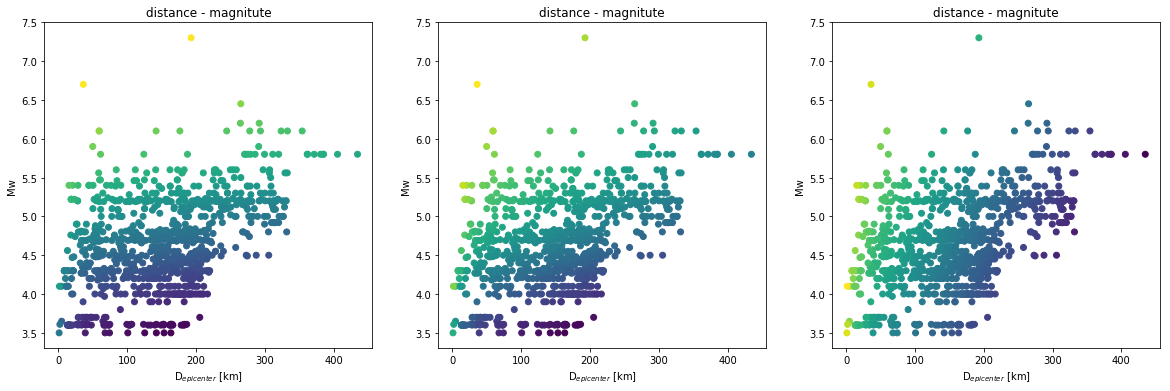

In [41]:
fig = plt.figure(1, figsize=(20, 6))

plt.subplot(131)
plt.scatter(data_M_D.loc[:,1], data_M_D.loc[:,0], c=data[:,20], cmap='viridis')
plt.title('distance - magnitute')
plt.xlabel('D$_{epicenter}$ [km]')
plt.ylabel('Mw')

plt.subplot(132)
plt.scatter(data_M_D.loc[:,1], data_M_D.loc[:,0], c=data[:,50], cmap='viridis')
plt.title('distance - magnitute')
plt.xlabel('D$_{epicenter}$ [km]')
plt.ylabel('Mw')

plt.subplot(133)
plt.scatter(data_M_D.loc[:,1], data_M_D.loc[:,0], c=data[:,80], cmap='viridis')
plt.title('distance - magnitute')
plt.xlabel('D$_{epicenter}$ [km]')
plt.ylabel('Mw')
plt.show()

#### Define training and test data.
The test and validation set include each about 1/10 of all data. The remaining data are used for training.
The training data are shuffled to avoid mini-batches that include several records from the same earthquake.  

In [43]:
batch_size = 128

n_data     = data.shape[0]
# n_train    = math.ceil(n_data*9/10/batch_size)*batch_size
n_train    = 900
n_test     = n_data - n_train
data_train = data[ :n_train]
data_test  = data[n_train:]

print("Number of training records:", data_train.shape[0])

Number of training records: 900


Plot frequency spectrum for 10 records for data visualization and to control data preparation.

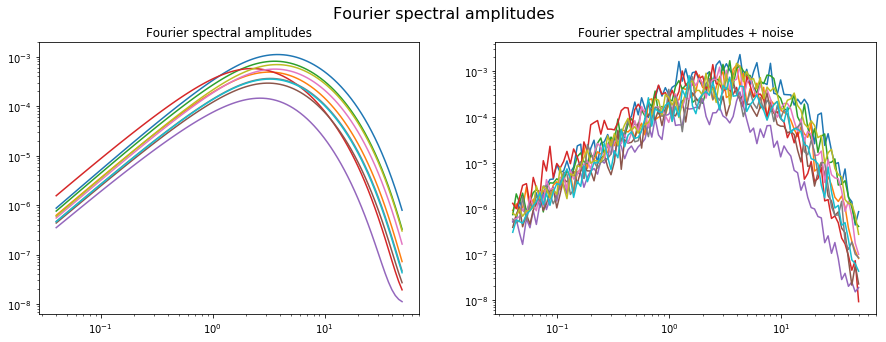

In [44]:
noise_level = 0.2
data_noisy  = data + noise_level * np.random.normal(size = data.shape)

fig = plt.figure(1, figsize=(15, 5))
fig.suptitle("Fourier spectral amplitudes", fontsize = 16)
for i in range(10):
  plt.subplot(121)
  plt.loglog(frequencies, np.power(10, data_train[i,:n_freq]))
  plt.title("Fourier spectral amplitudes")

  plt.subplot(122)
  plt.loglog(frequencies, np.power(10, data_noisy[i,:n_freq]))
  plt.title("Fourier spectral amplitudes + noise")
plt.show()

### Construct Autoencoder

#### Stacked Autoencoder with L2 regularization
We construct an autoencoder by iteratively increasing the depth and decreasing the number of nodes in the bottleneck.
In phase 1 we start with an autoencoder with one hidden layer that still includes a relative large number of nodes.
In each subsequent phase we nest in an additional layer of smaller size and thus decrease the dimension of the manifold on which the input data are mapped to. 
We use a decoder that is symmetric to the endocer. Thus, for each layer we add in the encoder, we add a layer of same size to the decoder.

In [45]:
## Define number and size of hidden layers
n_inputs  = data_train.shape[1]
n_outputs = n_inputs
n_hidden1 = 16
n_hidden2 = 2  
#n_hidden3 = 4
#n_hidden4 = 2 
#n_hidden3o = n_hidden3
n_hidden2o = n_hidden2
n_hidden1o = n_hidden1

## Define training settings
learning_rate = 0.01
l2_reg = 0.001

activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

########################
## Construct Autoencoder
inputs = tf.placeholder(tf.float32, shape=[None, n_inputs])
noise_level = .2
inputs_noisy = inputs + noise_level * tf.random_normal(tf.shape(inputs))
## define weight matrices
weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])
#weights3_init = initializer([n_hidden2, n_hidden3])
#weights4_init = initializer([n_hidden3, n_hidden4])
#weights4o_init = initializer([n_hidden4, n_hidden3o])
#weights3o_init = initializer([n_hidden3o, n_hidden2o])
weights2o_init = initializer([n_hidden2o, n_hidden1o])
weights1o_init = initializer([n_hidden1o, n_outputs])

weights1 = tf.Variable(weights1_init, dtype = tf.float32, name = "weights1in")
weights2 = tf.Variable(weights2_init, dtype = tf.float32, name = "weights2in")
#weights3 = tf.Variable(weights3_init, dtype = tf.float32, name = "weights3in")
#weights4 = tf.Variable(weights4_init, dtype = tf.float32, name = "weights4in")
#weights4o = tf.Variable(weights4o_init, dtype = tf.float32, name = "weights4out")
#weights3o = tf.Variable(weights3o_init, dtype = tf.float32, name = "weights3out")
weights2o = tf.Variable(weights2o_init, dtype = tf.float32, name = "weights2out")
weights1o = tf.Variable(weights1o_init, dtype = tf.float32, name = "weights1out")

## define biases
bias1 = tf.Variable(tf.zeros(n_hidden1), name = "biases1in")
bias2 = tf.Variable(tf.zeros(n_hidden2), name = "biases2in")
#bias3 = tf.Variable(tf.zeros(n_hidden3), name = "biases3in")
#bias4 = tf.Variable(tf.zeros(n_hidden4), name = "biases4in")
#bias4o = tf.Variable(tf.zeros(n_hidden3o), name = "biases4out")
#bias3o = tf.Variable(tf.zeros(n_hidden2o), name = "biases3out")
bias2o = tf.Variable(tf.zeros(n_hidden1o), name = "biases2out")
bias1o = tf.Variable(tf.zeros(n_outputs), name = "biases1out")

## define (hidden) layers
hidden1 = activation(tf.matmul(inputs_noisy,    weights1) + bias1)
hidden2 = activation(tf.matmul(hidden1,   weights2) + bias2)
#hidden3 = activation(tf.matmul(hidden2,   weights3) + bias3)
#hidden4 = activation(tf.matmul(hidden3,   weights4) + bias4)
#hidden3o = activation(tf.matmul(hidden4,  weights4o) + bias4o)
#hidden2o = activation(tf.matmul(hidden3o, weights3o) + bias3o)
hidden1o = activation(tf.matmul(hidden2, weights2o) + bias2o)
outputs  = tf.matmul(hidden1o, weights1o) + bias1o

reconstruction_loss = tf.reduce_mean(tf.square(outputs - inputs)) # MSE
optimizer = tf.train.AdamOptimizer(learning_rate)
#training_op = optimizer.minimize(loss)

# encoding form input to hidden1 and decode to output
with tf.name_scope("phase1"):
    phase1_outputs = tf.matmul(hidden1, weights1o) + bias1o
    phase1_reconstruction_loss = tf.reduce_mean(tf.square(phase1_outputs - inputs)) # MSE
    phase1_reg_loss = regularizer(weights1) + regularizer(weights1o)
    phase1_loss = phase1_reconstruction_loss + phase1_reg_loss
    phase1_training_op = optimizer.minimize(phase1_loss)

# extend autoencoder to 3 hidden layers    
# encoding from input to hidden1 to hidden2 and decode via hidden1o to output
with tf.name_scope("phase2"):
    phase2_hidden1o = activation(tf.matmul(hidden2, weights2o) + bias2o)
    phase2_outputs = tf.matmul(phase2_hidden1o, weights1o) + bias1o 
    phase2_reconstruction_loss = tf.reduce_mean(tf.square(phase2_outputs - inputs)) # MSE
    phase2_reg_loss = phase1_reg_loss + regularizer(weights2) + regularizer(weights2o)
    phase2_loss = phase2_reconstruction_loss + phase2_reg_loss
    phase2_training_op = optimizer.minimize(phase2_loss)          

init = tf.global_variables_initializer()

In [46]:
########################
## Train the autoencoder

with tf.Session() as sess:
    init.run()
    data_shuffle = data_train.copy()
    cur_pos = 0 # used to iterate over batches
    print("Phase1")
    for i in range(20001):
        if cur_pos + batch_size > n_train:
            np.random.shuffle(data_shuffle)
            cur_pos = 0            
        sess.run(phase1_training_op, feed_dict={inputs: data_shuffle[cur_pos:(cur_pos + batch_size),]})
        if i % 1000 == 0:
            train_loss = phase1_reconstruction_loss.eval(feed_dict={inputs: data_shuffle[cur_pos:(cur_pos + batch_size),]})
            test_loss = phase1_reconstruction_loss.eval(feed_dict={inputs: data_test[0:batch_size,]})
            print('step %d: training loss = %g, test loss: %g' % (i, train_loss, test_loss))
        cur_pos += batch_size
    phase1_out_values = phase1_outputs.eval(feed_dict = {inputs: data_test})
    
    print("Phase2")
    for i in range(20001):
        if cur_pos + batch_size > n_train:
            np.random.shuffle(data_shuffle)
            cur_pos = 0            
        sess.run(phase2_training_op, feed_dict={inputs: data_shuffle[cur_pos:(cur_pos + batch_size),]})
        if i % 1000 == 0:
            train_loss = phase2_reconstruction_loss.eval(feed_dict={inputs: data_shuffle[cur_pos:(cur_pos + batch_size),]})
            test_loss = phase2_reconstruction_loss.eval(feed_dict={inputs: data_test[0:batch_size,]})
            print('step %d: training loss = %g, test loss: %g' % (i, train_loss, test_loss))
        cur_pos += batch_size
    phase2_out_values = phase2_outputs.eval(feed_dict = {inputs: data_test})
    
    coding = sess.run(hidden2, feed_dict = {inputs: data}) 

Phase1
step 0: training loss = 27.8634, test loss: 25.7056
step 1000: training loss = 0.0119642, test loss: 0.0114637
step 2000: training loss = 0.00515588, test loss: 0.00545937
step 3000: training loss = 0.00227404, test loss: 0.00200965
step 4000: training loss = 0.00307354, test loss: 0.00275753
step 5000: training loss = 0.00220768, test loss: 0.00222472
step 6000: training loss = 0.00287924, test loss: 0.002775
step 7000: training loss = 0.00303962, test loss: 0.00303068
step 8000: training loss = 0.00167869, test loss: 0.00165014
step 9000: training loss = 0.00270705, test loss: 0.00252439
step 10000: training loss = 0.00170544, test loss: 0.00167734
step 11000: training loss = 0.00423765, test loss: 0.00402582
step 12000: training loss = 0.00245935, test loss: 0.00214093
step 13000: training loss = 0.00172571, test loss: 0.00180254
step 14000: training loss = 0.00218297, test loss: 0.00223447
step 15000: training loss = 0.0020053, test loss: 0.00205883
step 16000: training loss

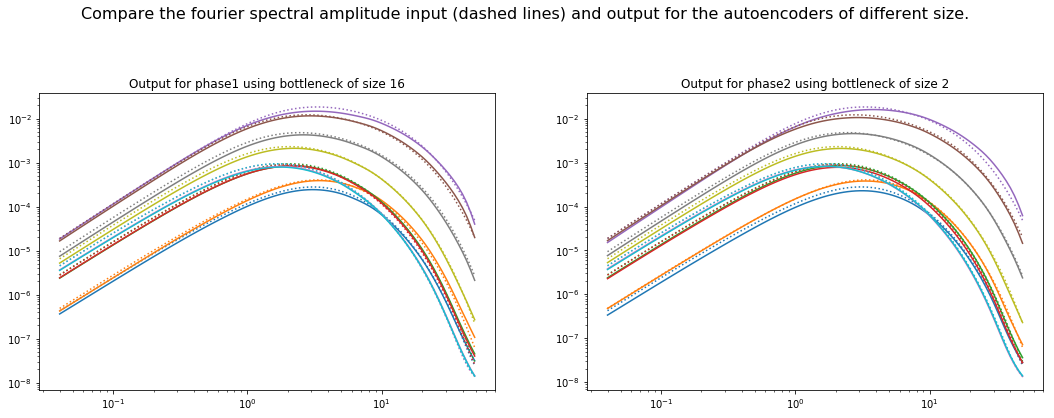

In [47]:
import matplotlib.colors as mcolors
fig = plt.figure(1, figsize=(18, 12))
fig.suptitle("Compare the fourier spectral amplitude input (dashed lines) and output for the autoencoders of different size.", fontsize = 16)
ylim = [10**(-6), 10]
for i in range(10):
  plt.subplot(221)
  plt.loglog(frequencies, np.power(10, phase1_out_values[i,:n_freq]))
  plt.loglog(frequencies, np.power(10, data_test[i,:n_freq]), linestyle = ":", 
             color = list(mcolors.TABLEAU_COLORS.values())[i])
  plt.title("Output for phase1 using bottleneck of size %d" % n_hidden1)
#  plt.ylim(ylim)

  plt.subplot(222)
  plt.loglog(frequencies, np.power(10, phase2_out_values[i,:n_freq]))
  plt.loglog(frequencies, np.power(10, data_test[i,:n_freq]), linestyle = ":", 
             color = list(mcolors.TABLEAU_COLORS.values())[i])
  plt.title("Output for phase2 using bottleneck of size %d" % n_hidden2)
#  plt.ylim(ylim)

plt.show()

### Visualize the ground motion records on the 2D manifold

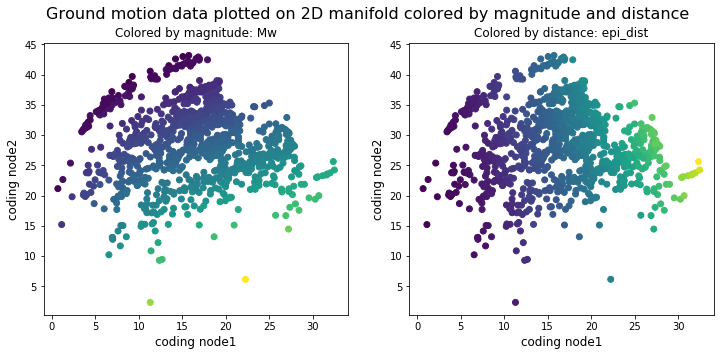

In [48]:
fig = plt.figure(1, figsize=(12, 5))
fig.suptitle("Ground motion data plotted on 2D manifold colored by magnitude and distance", fontsize = 16)

Mw_values = data_M_D.loc[:,0]
dist_values = data_M_D.loc[:,1]

plt.subplot(1,2,1)
plt.scatter(coding[:,0], coding[:,1], c=data_M_D.loc[:,0], cmap='viridis')
plt.xlabel('coding node1', fontsize = 12)
plt.ylabel('coding node2', fontsize = 12)
plt.title("Colored by magnitude: Mw")

plt.subplot(1,2,2)
plt.scatter(coding[:,0], coding[:,1], c=data_M_D.loc[:,1], cmap='viridis')
plt.xlabel('coding node1', fontsize = 12)
plt.ylabel('coding node2', fontsize = 12)
plt.title("Colored by distance: epi_dist")


plt.show()